# Г1 Сверточные сети
    выполнил Сергей Харитонов МИВТ-221

# Задание
Задание творческое. 1) Снимите короткое видео (не больше минуты) с некоторым объектом; в течение ролика должен быть промежуток, когда объект закрыт (полностью или частично) 2) Сделайте раскадровку видео 3) Постройте сверточную сеть (используя Keras), которая отделит кадры с объектом от кадров без объекта.


Разметим кадры из снятого видео и уменьшим размерность, а так же создадим чернобелые версии

In [1]:
import shutil
import os
from PIL import Image

DIR_PATH = os.getcwd()
DATA_PATH = os.path.join(DIR_PATH, 'data')
DATA_MARKUP_PATH = os.path.join(DIR_PATH, 'data_markup')
DATA_MARKUP_MONOCHROME_PATH = os.path.join(DIR_PATH, 'data_markup_monochrome')
# Все кадры видео
all_data = [
    file
    for file in os.listdir(DATA_PATH)
]
# Не размеченные кадры из видео
not_murk_up_file = [
    file
    for file in all_data
    if '_' not in file
]

print(f'Всего файлов: {len(all_data)}')
print(f'Не размеченных: {len(not_murk_up_file)}')

# 0 - на кадре нет ежа
# 1 - на кадре присутствует еж
# В словаре указаны диапазоны кадров подходящих под условие
RANGES_TO_FLAGS = {
    0: (
        (36, 80),
        (356, 420),
        (501, 780)
    ),
    1: (
        (1, 35),
        (81, 355),
        (421, 500)
    )
}


# получение названия неразмеченного файла по номеру кадра
def get_name(number: int) -> str:
    return f'{str(number).zfill(4)}.jpg'


# Проход по типам кадров
for flag, ranges in RANGES_TO_FLAGS.items():
    flag_counter = 0
    # Проход по диапазонам кадров принадлежащим к типу
    for start, end in ranges:
        # Переименование кадров в название с меткой flag
        for number in range(start, end + 1):
            prev_name, prev_ext = get_name(number).split('.')
            new_name = f"{flag}_{prev_name}.{prev_ext}"
            new_path = os.path.join(
                DATA_MARKUP_PATH,
                new_name
            )
            shutil.copyfile(
                os.path.join(DATA_PATH, f'{prev_name}.{prev_ext}'),
                new_path
            )

            # сжатие изображения
            image = Image.open(new_path)
            image = image.resize((216, 384), Image.BOX)
            image.save(new_path)

            # В чернобелый вид
            image.convert('L').save(
                os.path.join(
                    DATA_MARKUP_MONOCHROME_PATH,
                    new_name
                )
            )

            flag_counter += 1
    print(f"Всего кадров типа {flag}: {flag_counter}")

Всего файлов: 781
Не размеченных: 780
Всего кадров типа 0: 390
Всего кадров типа 1: 390


Загрузка изображений в память

In [2]:
import numpy as np
import matplotlib.pylab as plt
from random import shuffle

%matplotlib inline

# Функция для получения X и Y датасета
def load_data(path: str) -> (np.array, np.array):
    # Загрузка определенного типа изображений
    def load_images_by_cluster(cluster: int) -> np.array:
        data = [
            plt.imread(
                os.path.join(
                    path,
                    file
                )
            )
            for file in os.listdir(path)
            if int(file.split('_')[0]) == cluster
        ]
        shuffle(data)
        return np.array(data)


    with_hedgehog_images = load_images_by_cluster(1)
    without_hedgehog_images = load_images_by_cluster(0)

    # Добавление метки кластера
    def add_mark(data: np.array, cluster: int) -> [(np.array, int)]:
        return [
            (
                image,
                cluster
            )
            for image in data
        ]


    data = \
        add_mark(with_hedgehog_images, 1) \
        + \
        add_mark(without_hedgehog_images, 0)

    # Перемешиваем выборку
    shuffle(data)


    # Разделение выборки на X и Y
    x, y = list(zip(*data))
    return np.array(x), np.array(y)

Xs, Ys = load_data(DATA_MARKUP_PATH)
Xs_monochrome, Ys_monochrome = load_data(DATA_MARKUP_MONOCHROME_PATH)

Вывод информации об обучающей выборке

In [3]:
print(f'Размерность изображений: {Xs[0].shape}')
print(f'Размерность монохромного изображения: {Xs_monochrome[0].shape}')
print(f'Количество изображений в выборке: {Xs.shape[0]}')

Размерность изображений: (384, 216, 3)
Размерность монохромного изображения: (384, 216)
Количество изображений в выборке: 780


Описание модели сверточной нейронной сети для цветных картинок

In [4]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense, Normalization
from keras import Sequential

model = Sequential()
model.add(Normalization())
model.add(
    Conv2D(
        100,
        (5, 5),
        input_shape=Xs[0].shape,
        activation='relu',
        padding='same'
    )
)
model.add(Normalization())
model.add(MaxPooling2D((10, 10), padding='valid'))
model.add(
    Conv2D(
        50,
        (2, 2),
        activation='relu',
        padding='same'
    )
)
model.add(Normalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

Описание модели сверточной нейронной сети для чернобелых картинок

In [9]:
from keras.src.layers import MaxPooling1D
from keras.src.layers import Conv1D

model_monochrome = Sequential()
model_monochrome.add(Normalization())
model_monochrome.add(
    Conv1D(
        100,
        (5,),
        input_shape=Xs_monochrome[0].shape,
        activation='relu',
        padding='same'
    )
)
model_monochrome.add(Normalization())
model_monochrome.add(MaxPooling1D((10,), padding='valid'))
model_monochrome.add(
    Conv1D(
        50,
        (2,),
        activation='relu',
        padding='same'
    )
)
model_monochrome.add(Normalization())
model_monochrome.add(MaxPooling1D(pool_size=(2,), padding='valid'))
model_monochrome.add(Flatten())
model_monochrome.add(Dense(64, activation='relu'))
model_monochrome.add(Dense(32, activation='relu'))
model_monochrome.add(Dense(1, activation='sigmoid'))

model_monochrome.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

Функция визуализации результатов обучения

In [6]:
from datetime import datetime
from IPython.display import SVG
from keras.utils import model_to_dot

def teach(model, Xs, Ys, postfix):
    start = datetime.now()

    history = model.fit(
       Xs, Ys,
        batch_size=10,
        epochs=10,
        verbose=1,
        validation_split=0.1
    )
    end = datetime.now()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'model accuracy {postfix}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model loss {postfix}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    print(f'Время обучения: {end - start}')
    print(f'Итоговая точность на тренировочной выборке: {history.history["accuracy"][-1]}')
    print(f'Итоговая точность на тестовой выборке: {history.history["val_accuracy"][-1]}')
    print(f'Итоговая ошибка на тренировочной выборке: {history.history["loss"][-1]}')
    print(f'Итоговая ошибка на тестовой выборке: {history.history["val_loss"][-1]}')
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

Обучение для цветных изображений

Epoch 1/10
71/71 [==============================] - 26s 363ms/step - loss: 2.9821 - accuracy: 0.8205 - val_loss: 0.0394 - val_accuracy: 1.0000
Epoch 2/10
71/71 [==============================] - 25s 351ms/step - loss: 0.0325 - accuracy: 0.9886 - val_loss: 0.0296 - val_accuracy: 0.9872
Epoch 3/10
71/71 [==============================] - 25s 347ms/step - loss: 0.0291 - accuracy: 0.9886 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 4/10
71/71 [==============================] - 25s 348ms/step - loss: 0.0194 - accuracy: 0.9886 - val_loss: 0.0126 - val_accuracy: 0.9872
Epoch 5/10
71/71 [==============================] - 25s 349ms/step - loss: 0.0336 - accuracy: 0.9886 - val_loss: 0.1934 - val_accuracy: 0.9103
Epoch 6/10
71/71 [==============================] - 25s 347ms/step - loss: 1.5414 - accuracy: 0.7678 - val_loss: 1.5414 - val_accuracy: 0.5256
Epoch 7/10
71/71 [==============================] - 24s 344ms/step - loss: 0.2262 - accuracy: 0.9530 - val_loss: 0.0249 - val_accuracy: 0.9872

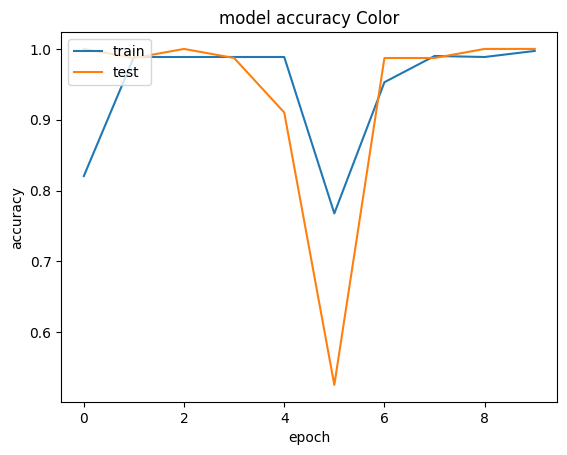

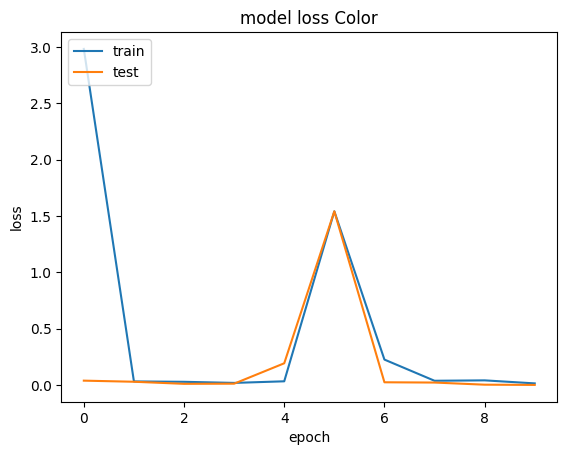

Время обучения: 0:04:07.880184
Итоговая точность на тренировочной выборке: 0.9971510171890259
Итоговая точность на тестовой выборке: 1.0
Итоговая ошибка на тренировочной выборке: 0.015022266656160355
Итоговая ошибка на тестовой выборке: 0.0014775670133531094


In [7]:
teach(model, Xs, Ys, 'Color')

Обучение для чернобелых изображений

Epoch 1/10
71/71 [==============================] - 2s 20ms/step - loss: 4.6881 - accuracy: 0.7322 - val_loss: 0.2584 - val_accuracy: 0.8974
Epoch 2/10
71/71 [==============================] - 1s 14ms/step - loss: 0.4634 - accuracy: 0.9017 - val_loss: 0.6950 - val_accuracy: 0.8333
Epoch 3/10
71/71 [==============================] - 1s 14ms/step - loss: 0.2897 - accuracy: 0.9188 - val_loss: 0.2124 - val_accuracy: 0.8974
Epoch 4/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0886 - accuracy: 0.9672 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 5/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/10
71/71 [==============================] - 1s 14ms/step - loss: 0.6740 - accuracy: 0.9046 - val_loss: 0.0327 - val_accuracy: 0.9872
Epoch 7/10
71/71 [==============================] - 1s 14ms/step - loss: 0.1090 - accuracy: 0.9672 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/10
71

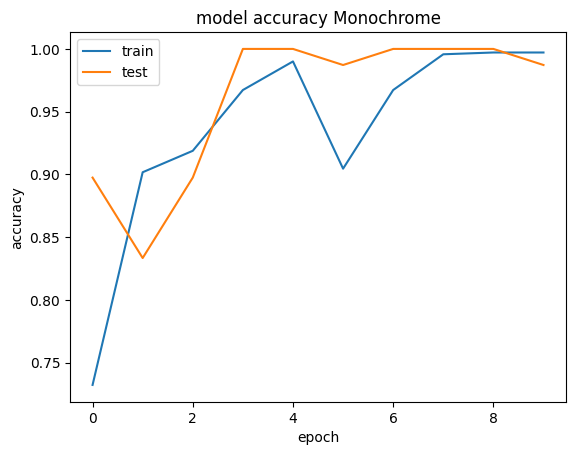

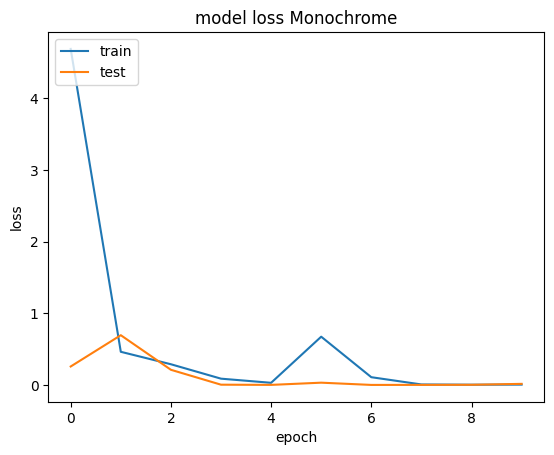

Время обучения: 0:00:11.075703
Итоговая точность на тренировочной выборке: 0.9971510171890259
Итоговая точность на тестовой выборке: 0.9871794581413269
Итоговая ошибка на тренировочной выборке: 0.005624134559184313
Итоговая ошибка на тестовой выборке: 0.016163203865289688


In [10]:
teach(model_monochrome, Xs_monochrome, Ys_monochrome, 'Monochrome')

# Вывод
В ходе обучения сверточной сети были получены высокие результаты распознования
для цветных изображений - 99%
для чернобелых -98%

Так же было замечено, что время затрачиваемое на обучение на чернобелых изображений в десятки раз меньше при не значительной разнице в качестве распознавания
для цветных изображений - 0:04:07.880184
для чернобелых - 0:00:11.075703

